In [15]:
import os
import time; start_time = time.time()
import importlib as imp
import pyEW
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib import rc
import numpy as np
import warnings
import dill
import pandas as pd
import json
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans']})

mpl.rcParams['axes.linewidth'] = 0.5

In [17]:
# time 
t_end = 1*365 # [d]: number of simulated days
dt = 1/(24*6) # [time resolution (d)]
t=np.arange(0,t_end,dt)

#units
conv_mol = 1e6 # Conversion from moles to micromols 
conv_Al = 1e3 # Conversion for Al species from mols to nanomols

#water balance
keyword_wb = 1 # 1 = varying soil moisture. 0 = constant soil moisture

#background inputs of cations and anions
keyword_add = 1 # 1 = balance background losses. 0 = no addition

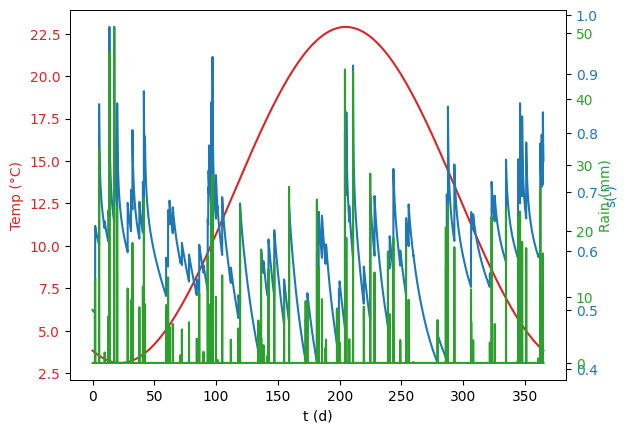

In [18]:
# HYDROCLIMATE AND WATER BALANCE

#soil 
soil = "loam" #sand, loamy sand, sandy loam, loam, clay loam, clay
Zr = 0.3 # [m]: soil depth
rho_bulk = 1.2*1e6 #soil dry mass (g/m3)
s_in = 0.5

#hydroclimatic
day1 = 1 #initial DOY
latitude = 40*np.pi/180 # [radians]
albedo = 0.25
altitude = 33 #[m]
wind = 1*np.ones(len(t)) #[m/s]
coastal = False 
temp_av = 13 # [°C] yearly average
temp_ampl_yr= 11 # [°C] yearly amplitude
temp_ampl_d= 5 # [°C] daily amplitude

#temp [Celsius]
[temp_air,temp_soil,temp_min,temp_max] = pyEW.temp(latitude,temp_av, temp_ampl_yr, temp_ampl_d, Zr,t_end,dt,day1)

#ET0 [m/d]
ET0 = pyEW.ET0(latitude,altitude,temp_air,temp_soil,temp_min,temp_max, wind,albedo,Zr,coastal,t_end,dt,day1)

#deterministic rain [m]
# Rain_yr = 0.8 # [m]: yearly rain
# t_rain = 7 #[d]: between rain event
# rain = np.zeros(len(t))
# j = 1
# while j < len(rain):
#     rain[j] = Rain_yr/(365/t_rain)
#     j = j+int(t_rain/dt)

#stochastic rain [m]
R_tot = 1.2 # [m/yr]
lamda = 0.25 # [d^(-1)]: average rain frequency 
alfa = (R_tot/lamda)/365 # [m]: average rain depth 
rain =pyEW.rain_stoc(lamda, alfa, t_end, dt)

#stochastic rain with seasonality [m] (only works with multi-year)
#lamda = np.array([0.47, 0.47, 0.4, 0.3, 0.18, 0.11, 0.04, 0.08, 0.28, 0.37, 0.45, 0.45]) # [d^(-1)]: average rain frequency 
#alfa = 10**(-3)*np.array([15, 15, 15, 13, 8, 12, 14, 19, 18, 18, 16, 15]) # [mm converted to m]: average rain depth 
#rain =pyEW.rain_stoc_season(lamda, alfa, t_end, dt)

#vegetation [g/m2]
T_v = 100 # [d] growth time
k_v = 3000 # [g/m2] carrying capacity
RAI = 10 #[m2/m2] root area index
root_d = 0.4*1e-3 #[m] average root diameter
v_in = 1*k_v # [g/m2] ic
t0_v = 0 # [d] starting day of growth
v = pyEW.veg(v_in, T_v, k_v, t0_v, temp_soil, dt)

#moisture balance (I, Q [m], L, T, E [m/d])
[s, s_w, s_i, I, L, T, E, Q, Irr, n] = pyEW.moisture_balance(rain, Zr, soil, ET0, v, k_v, keyword_wb, s_in,t_end,dt)

#Temp
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('t (d)')
ax1.set_ylabel('Temp (°C)', color=color)
ax1.plot(t, temp_soil, color=color)
ax1.tick_params(axis='y', labelcolor=color)

#moisture
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('s(-)', color=color)
ax2.plot(t, s, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# rainfall
ax3 = ax1.twinx()
color = 'tab:green'
ax3.set_ylabel('Rain (mm)', color=color)
ax3.plot(t, rain*1e3, color=color)  # Note the swapping of x and y data
ax3.tick_params(axis='y', labelcolor=color)

plt.show()

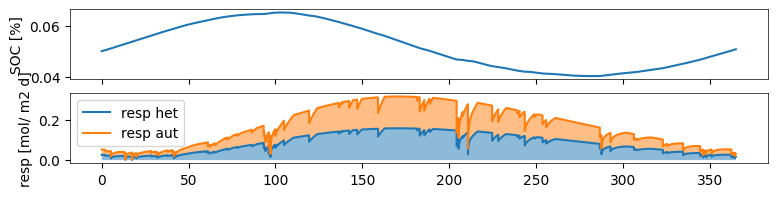

In [19]:
# ORGANIC CARBON and RESPIRATION
CO2_atm = pyEW.CO2_atm(conv_mol)

#initial pCO2
CO2_air_in = 10*CO2_atm # CO2 in soil air [mol-conv/l] 
ratio_aut_het = 1

#Initial organic carbon
ADD = 1 # added dry litter [gOC/(m2*d)]
SOC_perc = 0.05 # [%]
SOC_in = rho_bulk*SOC_perc/100 #[gOC/m3] 

#SOC balance and respiration
[SOC, r_het, r_aut, D] = pyEW.respiration(ADD, SOC_in, CO2_air_in, ratio_aut_het, soil, s, v, k_v, Zr, temp_soil,dt,conv_mol)

# Create a figure and subplots
fig, axs = plt.subplots(2, 1,figsize=(9, 2))

# Plot the quantities in each subplot
axs[0].plot(t,100*SOC/(rho_bulk),label='crop')
axs[0].set_xticklabels([])
axs[0].set_ylabel('SOC [%]')
axs[1].plot(t, r_het/conv_mol, label = 'resp het')
axs[1].plot(t, (r_het+r_aut)/conv_mol, label = 'resp aut')
axs[1].fill_between(t, r_het/conv_mol, 0, alpha=0.5)
axs[1].fill_between(t, (r_het+r_aut)/conv_mol, r_het/conv_mol,alpha=0.5)
axs[1].legend()
axs[1].set_ylabel('resp [mol/ m2 d]')

# Display the combined graph
plt.show()

In [20]:
# SOIL BIOGEOCHEMISTRY

#initial pH
pH_in = 4

#CEC 
CEC_tot = 10 # [mmol_c / 100 g dry-soil] 
CEC_tot = CEC_tot*1e-5*rho_bulk*Zr*conv_mol # [mol_c] 

#CEC fractions
f_Ca_in = 0.3
f_Mg_in = 0.15
f_K_in = 0.1
f_Na_in = 0.05
f_Al_in = 0
f_H_in = 0.4

f_CEC_in = np.array([f_Ca_in, f_Mg_in, f_K_in, f_Na_in, f_Al_in, f_H_in]) 
if abs(sum(f_CEC_in)-1) > 1e-3:
    raise ValueError("Sum of fractions must be 1")
    
#carbonates
CaCO3_in = 0
MgCO3_in = 0

#conc water
Si_in = 0 
[conc_in, K_CEC] = pyEW.f_CEC_to_conc(f_CEC_in, pH_in, soil, conv_mol,conv_Al)
    
#EW application
M_rock_in = 1000 # [g/m2] of added rock powder
mineral = ["forsterite"] 
rock_f_in = np.array([1]) # mineral fractions
diss_f = 1 # dissolution factor
d_in = np.array([100])*1e-6 # [m]: diameter classes
psd_perc_in = np.array([1]) # diameter class weight (%)
SSA_in = np.nan # [m2/g]: either measured value or nan to estimate it
t_app = 0 # day of application

data = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

/workspaces/SMEW_SS/pyEW/biogeochem.py:370: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(equations,x0, xtol=1e-12)


<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:69: SyntaxWarning: invalid escape sequence '\m'
<>:93: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:69: SyntaxWarning: invalid escape sequence '\m'
<>:93: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3801/2533239208.py:49: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_ylabel('[Alk] ($\mu$mol/l)', color=color)
/tmp/ipykernel_3801/2533239208.py:62: SyntaxWarning: invalid escape sequence '\m'
  labels = ['[CO$_3^{2-}$]',  '[HCO$_3^{-}$]', '[CO$_2]_\mathrm{w}$', '[CO$_2]_\mathrm{a}$']
/tmp/ipykernel_3801/2533239208.py:62: SyntaxWarning: invalid escape sequence '\m'
  labels = ['[CO$_3^{2-}$]',  '[HCO$_3^{-}$]', '[CO$_2]_\mathrm{w}$', '[CO$_2]_\mathrm{a}$']
/tmp/i

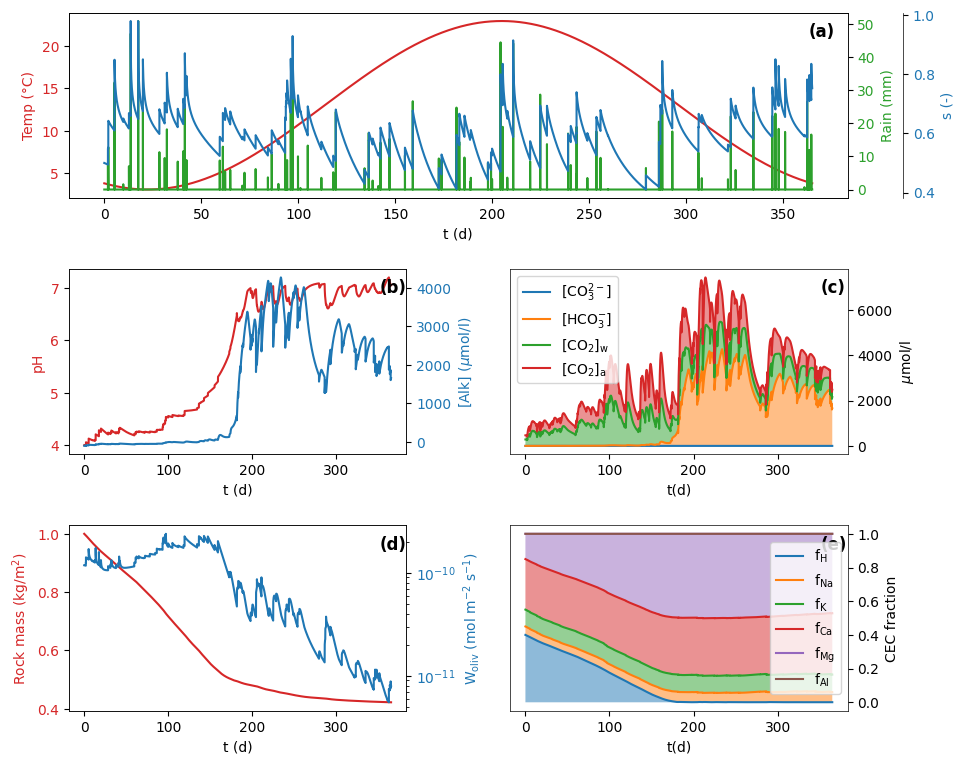

In [21]:
# Create a figure and subplots
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 2)

#--------------------------------------------------------------------------------
# First panel - Hydroclimatic
#--------------------------------------------------------------------------------

axs1 = plt.subplot(gs[0, :])

#Temp
color = 'tab:red'
axs1.set_xlabel('t (d)')
axs1.set_ylabel('Temp (°C)', color=color)
axs1.plot(t, temp_soil, color=color)
axs1.tick_params(axis='y', labelcolor=color)

# rainfall
ax2 = axs1.twinx()
color = 'tab:green'
ax2.set_ylabel('Rain (mm)', color=color)
ax2.plot(t, rain*1e3, color=color)  # Note the swapping of x and y data
ax2.tick_params(axis='y', labelcolor=color)

#moisture
ax3 = axs1.twinx()
color = 'tab:blue'
ax3.set_ylabel('s (-)', color=color)
ax3.plot(t, s, color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.spines['right'].set_position(('outward', 40))

#--------------------------------------------------------------------------------
# Second panel - pH and Alk
#--------------------------------------------------------------------------------

axs2 = plt.subplot(gs[1, 0])

#pH
color = 'tab:red'
axs2.set_xlabel('t (d)')
axs2.set_ylabel('pH', color=color)
axs2.plot(t, data['pH'], color=color)
axs2.tick_params(axis='y', labelcolor=color)

# Alk
ax2 = axs2.twinx()
color = 'tab:blue'
ax2.set_ylabel('[Alk] ($\mu$mol/l)', color=color)
ax2.plot(t, data['Alk'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
#axs2.set_xticklabels([])

#--------------------------------------------------------------------------------
# Third panel - IC
#--------------------------------------------------------------------------------

axs3 = plt.subplot(gs[1, 1])

cumulative_sum = 0
i = 0
labels = ['[CO$_3^{2-}$]',  '[HCO$_3^{-}$]', '[CO$_2]_\mathrm{w}$', '[CO$_2]_\mathrm{a}$']
for element in ['CO3', 'HCO3', 'CO2_w', 'CO2_air']:
    axs3.plot(t, data[element] + cumulative_sum, label=labels[i])
    axs3.fill_between(t, cumulative_sum, cumulative_sum + data[element], alpha=0.5)
    i = i + 1
    cumulative_sum += data[element]
    
axs3.set_ylabel('$\mu$mol/l')
axs3.set_xlabel('t(d)')
#axs3.set_xticklabels([])
axs3.yaxis.tick_right()
axs3.yaxis.set_label_position("right")   
axs3.legend()

#--------------------------------------------------------------------------------
# Forth panel - Weathering
#--------------------------------------------------------------------------------

axs4 = plt.subplot(gs[2, 0])

color = 'tab:red'
axs4.set_xlabel('t (d)')
axs4.set_ylabel('Rock mass (kg/m$^2$)', color=color)
axs4.plot(t, 1e-3*data['M_rock'][:], color=color)
axs4.tick_params(axis='y', labelcolor=color)

# Alk
ax2 = axs4.twinx()
color = 'tab:blue'
ax2.plot(t,data['Wr'][0,:]/(conv_mol*24*3600), color=color)
ax2.set_yscale('log')
ax2.set_ylabel('W$_\mathrm{oliv}$ (mol m$^{-2}$ s$^{-1}$)',color=color)
ax2.tick_params(axis='y', labelcolor=color)

#--------------------------------------------------------------------------------
# Fifth panel - CEC
#--------------------------------------------------------------------------------

axs5 = plt.subplot(gs[2, 1])

cumulative_sum = 0
labels = [r'f$_\mathrm{H}$', r'f$_\mathrm{Na}$', r'f$_\mathrm{K}$', r'f$_\mathrm{Ca}$', r'f$_\mathrm{Mg}$', r'f$_\mathrm{Al}$']
i=0
for element in ['f_H', 'f_Na', 'f_K', 'f_Ca', 'f_Mg', 'f_Al']:
    axs5.plot(t, data[element] + cumulative_sum, label=labels[i])
    axs5.fill_between(t, cumulative_sum, cumulative_sum + data[element], alpha=0.5)
    cumulative_sum += data[element]
    i=i+1

axs5.set_ylabel('CEC fraction')
axs5.set_xlabel('t(d)')
axs5.yaxis.tick_right()
axs5.yaxis.set_label_position("right")
axs5.legend()

#-------------------------------------------------------------------
#plot labels
axs1.text(0.95, 0.87, '(a)', transform=axs1.transAxes, fontsize=12, fontweight='bold', zorder = 3)
axs2.text(0.92, 0.87, '(b)', transform=axs2.transAxes, fontsize=12, fontweight='bold', zorder = 3)
axs3.text(0.92, 0.87, '(c)', transform=axs3.transAxes, fontsize=12, fontweight='bold', zorder = 3)
axs4.text(0.92, 0.87, '(d)', transform=axs4.transAxes, fontsize=12, fontweight='bold', zorder = 3)
axs5.text(0.92, 0.87, '(e)', transform=axs5.transAxes, fontsize=12, fontweight='bold', zorder = 3)

#plotting
plt.tight_layout(pad=2.0)
plt.show()